In [38]:
#Initializing
import pandas as pd
import numpy as np
import glob
import statsmodels.formula.api as sm
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics, svm
from sklearn.metrics import silhouette_samples, silhouette_score
#Taken straight from Lecture 17- Clustering1 to make our lives easier
cmap2 = ListedColormap(["#e41a1c","#984ea3","#a65628","#377eb8","#ffff33","#4daf4a","#ff7f00"])

%matplotlib inline 

In [2]:
#Reloading the data
cleanfiles=glob.glob('outliers_ded/no_outliers*.csv') #use glob to make list of file names
data=[]
for filename in cleanfiles:
    data.append(pd.read_csv(filename))
print(data[0].head())

  class  redshift  redshift_err  green_mag  green_err  green_ext   red_mag  \
0   QSO  2.394828      0.000523   21.59155   0.052753   0.053609  21.73227   
1   QSO  2.835478      0.000364   19.03116   0.010645   0.088698  18.89552   
2   QSO  0.724055      0.262761   22.39019   0.115262   0.169662  21.73291   
3   QSO  0.916071      0.000296   19.29613   0.012580   0.177208  19.10373   
4   QSO  1.871305      0.000318   19.30308   0.012689   0.158918  19.14062   

    red_err   red_ext       velocity          Flux      distance  
0  0.093848  0.037086  251920.860836  6.565051e-17  11348.034569  
1  0.011655  0.061361  261628.811052  6.940554e-16   3490.138408  
2  0.088681  0.117372  148853.427213  3.146170e-17  16392.630515  
3  0.012747  0.122592  171438.185701  5.437586e-16   3943.089639  
4  0.013156  0.109939  234933.147635  5.402890e-16   3955.730083  


In [3]:
#Pandas can create dummies for us because they are awesome.

labelframe = [0]*40
mask = ['class']

for i in range(len(data)):
    try:
        dummy = pd.get_dummies(data[i], columns=mask)
        labelframe[i] = dummy
    except:
        continue   

In [4]:
labelframe[0].dtypes

redshift        float64
redshift_err    float64
green_mag       float64
green_err       float64
green_ext       float64
red_mag         float64
red_err         float64
red_ext         float64
velocity        float64
Flux            float64
distance        float64
class_GALAXY      uint8
class_QSO         uint8
dtype: object

In [5]:
#Running some calculations to get the variables we need for our clustering and our classifiers, and then 
#fixing some minor problems in the data
i=0
c=299792.458 #speed of light in km/s
H_o = 43.57285 #our experimental value from part 1
for i in range(len(labelframe)):
    M_Abs=[]
    Term2 = []
    m_apparent = []
    green = []
    red = []
    g_r = []
    for m in labelframe[i]["red_mag"]:
        m_apparent.append(m)
    for z in labelframe[i]['redshift']:
        #for our data, and for the purposes of these calculations, 
        #there shouldn't be and negative redshifts. Luckily, only a handful are below
        #zero in any dataframe in the collection. We decided to set them to 
        #zero if they were negative, but this caused errors in the calculations
        #that followed. We then decided that 1e-16 was "close enough" to zero for our purposes.
        if z<0:
            z=1e-16
        Term2.append(5*np.log((z*c)/H_o)+5) #Part of our calculation for Absolute Magnitude
    for a in range(len(m_apparent)):
        M_Abs.append(m_apparent[a] - Term2[a]) #2nd step of our calculation for Absolute Magnitude
    for j in range(len(M_Abs)):
        M_Abs[j] = M_Abs[j] - labelframe[i]["red_ext"][j] #3rd step of our calculation, subtracting off exctinction
    for g in labelframe[i]["green_mag"]:
        green.append(g) #"g" in "g-r"
    for r in labelframe[i]["red_mag"]:
        red.append(r) #"r" in "g-r"
    for rg in range(len(green)):
        g_r.append(green[rg]-red[rg]) #Finishing calculation for (g-r)
    labelframe[i]['M_Absolute']=M_Abs
    labelframe[i]["G_minus_R"]=g_r
    

labelframe[1].head()

,redshift,redshift_err,green_mag,green_err,green_ext,red_mag,red_err,red_ext,velocity,Flux,distance,class_GALAXY,class_QSO,M_Absolute,G_minus_R
0,1.745513,0.000946,21.12132,0.038946,0.059247,20.56920,0.038601,0.040987,229565.702602,1.012349e-16,9138.494401,0,1,-31.439086,0.55212
1,2.403731,0.000524,21.25386,0.033762,0.178415,21.40829,0.054750,0.123427,252151.092295,8.960126e-17,9713.654453,0,1,-32.282305,-0.15443
2,2.206132,0.000227,20.77077,0.025921,0.113221,20.83486,0.036250,0.078326,246634.385114,1.398138e-16,7776.150370,0,1,-32.381727,-0.06409
3,2.819490,0.000214,18.52347,0.007180,0.128278,18.16512,0.007021,0.088742,261329.182667,1.107822e-15,2762.515033,0,1,-36.288460,0.35835
4,0.399321,0.000040,19.97010,0.018123,0.057557,19.87769,0.021732,0.039818,97099.829021,2.922928e-16,5378.122004,0,1,-24.754237,0.09241


In [6]:
labelframe[1].describe()
#We are getting some outliers, so let's get rid of 'em.

,redshift,redshift_err,green_mag,green_err,green_ext,red_mag,red_err,red_ext,velocity,Flux,distance,class_GALAXY,class_QSO,M_Absolute,G_minus_R
count,14164.000000,14164.000000,14164.000000,14164.000000,14164.000000,14164.000000,14164.000000,14164.000000,14164.000000,1.416400e+04,14164.000000,14164.000000,14164.000000,14164.000000,14164.000000
mean,0.621464,0.011147,19.784473,-0.617276,0.124662,18.639190,-0.668014,0.086241,108257.817901,inf,1498.091452,0.812059,0.187941,-25.610948,1.145283
std,0.681362,0.456484,84.210065,84.017140,0.142622,84.195760,84.016640,0.098665,67959.561880,NaN,3558.075815,0.390679,0.390679,84.314417,0.653753
min,-0.000325,-6.000000,-9999.000000,-9999.000000,0.009221,-9999.000000,-9999.000000,0.006379,-97.440285,2.015942e-18,0.000000,0.000000,0.000000,-10035.602686,-3.312290
25%,0.176800,0.000032,18.762995,0.011588,0.062427,17.777385,0.008625,0.043187,48379.127559,4.503012e-17,0.728498,1.000000,0.000000,-26.222650,0.637123
50%,0.470836,0.000108,20.984185,0.048101,0.096387,19.833070,0.027280,0.066680,110251.853500,1.148641e-16,2.666513,1.000000,0.000000,-25.314471,1.225465
75%,0.627544,0.000188,22.000887,0.126090,0.154049,20.674855,0.055461,0.106570,135473.079875,8.885057e-16,4.579538,1.000000,0.000000,-22.820959,1.688060
max,6.963484,30.388700,25.373450,2.386329,5.840158,23.464750,2.126450,4.040194,290484.601450,inf,64759.076987,1.000000,1.000000,158.091882,4.402670


In [7]:
#KILLING them outliers

for i in range(len(labelframe)):
    killer = labelframe[i][labelframe[i]["M_Absolute"]>-50]
    killer2 = killer[killer["M_Absolute"]<-1]
    killer3 = killer2[killer2["G_minus_R"]>-2]
    labelframe[i] = killer3

labelframe[1].describe()

,redshift,redshift_err,green_mag,green_err,green_ext,red_mag,red_err,red_ext,velocity,Flux,distance,class_GALAXY,class_QSO,M_Absolute,G_minus_R
count,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,1.414800e+04,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000
mean,0.622152,0.011159,20.491711,0.088704,0.124291,19.345216,0.037740,0.085984,108375.933582,9.222251e-16,1499.783501,0.811846,0.188154,-25.008952,1.146496
std,0.681439,0.456741,1.906361,0.118629,0.140709,1.685859,0.037369,0.097342,67906.513286,3.740824e-15,3559.731303,0.390849,0.390849,4.149291,0.651926
min,0.003318,-6.000000,12.728550,0.001710,0.009221,11.854490,0.001542,0.006379,992.934169,2.015942e-18,0.042836,0.000000,0.000000,-41.806911,-1.648030
25%,0.177812,0.000032,18.761733,0.011587,0.062398,17.776752,0.008619,0.043167,48630.235195,4.500400e-17,0.728388,1.000000,0.000000,-26.224007,0.639620
50%,0.471315,0.000108,20.983980,0.048101,0.096372,19.830750,0.027276,0.066670,110336.187120,1.148857e-16,2.670710,1.000000,0.000000,-25.317063,1.226985
75%,0.627880,0.000188,22.001518,0.126173,0.153962,20.674067,0.055446,0.106510,135522.279570,8.895393e-16,4.582587,1.000000,0.000000,-22.838019,1.688410
max,6.963484,30.388700,25.373450,2.386329,5.840158,23.464750,0.630791,4.040194,290484.601450,2.303765e-13,64759.076987,1.000000,1.000000,-2.703713,4.402670


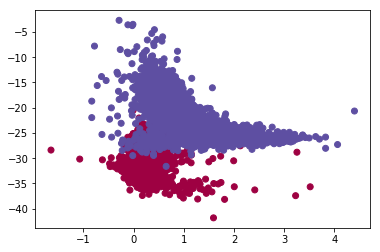

In [8]:
plt.scatter(labelframe[1]['G_minus_R'], labelframe[1]['M_Absolute'], c=labelframe[1]["class_GALAXY"],  marker="o", cmap="Spectral")

In [9]:
#We can see that in the "Red" area, everything is a galaxy. In the "Blue" area,
#everything is a Quasar, and in the "Green" valley, there is a mix.

In [10]:
#We know there are 3 clusters, "red", "blue", and "green" galaxies,
#so we will use 3 centers.
#Normally, you would test several different numbers of centers 
#and see which one performed the best using metrics, but since we already know
#that there are 3 groups (red, blue, green), we are going to go straight to 3 groups.

for i in range(len(labelframe)):
    X = labelframe[i][['M_Absolute','G_minus_R']]
    y_pred = KMeans(n_clusters=3, n_init=100, init='random', max_iter=5).fit_predict(X)
    labelframe[i]["K_Means_Cluster"] = y_pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [11]:
labelframe[1].describe()

,redshift,redshift_err,green_mag,green_err,green_ext,red_mag,red_err,red_ext,velocity,Flux,distance,class_GALAXY,class_QSO,M_Absolute,G_minus_R,K_Means_Cluster
count,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,1.414800e+04,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000
mean,0.622152,0.011159,20.491711,0.088704,0.124291,19.345216,0.037740,0.085984,108375.933582,9.222251e-16,1499.783501,0.811846,0.188154,-25.008952,1.146496,1.385072
std,0.681439,0.456741,1.906361,0.118629,0.140709,1.685859,0.037369,0.097342,67906.513286,3.740824e-15,3559.731303,0.390849,0.390849,4.149291,0.651926,0.837303
min,0.003318,-6.000000,12.728550,0.001710,0.009221,11.854490,0.001542,0.006379,992.934169,2.015942e-18,0.042836,0.000000,0.000000,-41.806911,-1.648030,0.000000
25%,0.177812,0.000032,18.761733,0.011587,0.062398,17.776752,0.008619,0.043167,48630.235195,4.500400e-17,0.728388,1.000000,0.000000,-26.224007,0.639620,1.000000
50%,0.471315,0.000108,20.983980,0.048101,0.096372,19.830750,0.027276,0.066670,110336.187120,1.148857e-16,2.670710,1.000000,0.000000,-25.317063,1.226985,2.000000
75%,0.627880,0.000188,22.001518,0.126173,0.153962,20.674067,0.055446,0.106510,135522.279570,8.895393e-16,4.582587,1.000000,0.000000,-22.838019,1.688410,2.000000
max,6.963484,30.388700,25.373450,2.386329,5.840158,23.464750,0.630791,4.040194,290484.601450,2.303765e-13,64759.076987,1.000000,1.000000,-2.703713,4.402670,2.000000


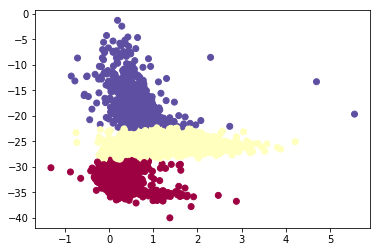

In [12]:
plt.scatter(labelframe[39]["G_minus_R"], labelframe[39]['M_Absolute'], c=labelframe[39]["K_Means_Cluster"],  marker="o", cmap="Spectral")

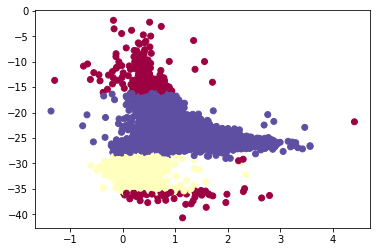

In [13]:
#DBSCAN Clustering. Note we originally used a 
#loop to do all 40, but it crashed everything hard.
#Here is the best example that we found.

X = labelframe[0][['M_Absolute','G_minus_R']]
db_model = DBSCAN(eps=1.5, min_samples=750)
db_model.fit(X)
y_pred = db_model.fit_predict(X)
labelframe[0]["DBSCAN_Cluster"] = y_pred

plt.scatter(labelframe[0]["G_minus_R"], labelframe[0]['M_Absolute'], c=labelframe[0]["DBSCAN_Cluster"],  marker="o", cmap="Spectral")

In [14]:
#Extremely sensitive to epsilon and min samples values.
#Especially min samples, which needs to be manually tested on each dataset of
#different sizes.
#K-means clustering is better for our data, since it all kind of "mashes together"
#into a blob, so hierarchical or DBSCAN clustering will perform poorly in comparison

In [21]:
labelframe[1].describe()

,redshift,redshift_err,green_mag,green_err,green_ext,red_mag,red_err,red_ext,velocity,Flux,distance,class_GALAXY,class_QSO,M_Absolute,G_minus_R,K_Means_Cluster
count,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,1.414800e+04,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000
mean,0.622152,0.011159,20.491711,0.088704,0.124291,19.345216,0.037740,0.085984,108375.933582,9.222251e-16,1499.783501,0.811846,0.188154,-25.008952,1.146496,1.385072
std,0.681439,0.456741,1.906361,0.118629,0.140709,1.685859,0.037369,0.097342,67906.513286,3.740824e-15,3559.731303,0.390849,0.390849,4.149291,0.651926,0.837303
min,0.003318,-6.000000,12.728550,0.001710,0.009221,11.854490,0.001542,0.006379,992.934169,2.015942e-18,0.042836,0.000000,0.000000,-41.806911,-1.648030,0.000000
25%,0.177812,0.000032,18.761733,0.011587,0.062398,17.776752,0.008619,0.043167,48630.235195,4.500400e-17,0.728388,1.000000,0.000000,-26.224007,0.639620,1.000000
50%,0.471315,0.000108,20.983980,0.048101,0.096372,19.830750,0.027276,0.066670,110336.187120,1.148857e-16,2.670710,1.000000,0.000000,-25.317063,1.226985,2.000000
75%,0.627880,0.000188,22.001518,0.126173,0.153962,20.674067,0.055446,0.106510,135522.279570,8.895393e-16,4.582587,1.000000,0.000000,-22.838019,1.688410,2.000000
max,6.963484,30.388700,25.373450,2.386329,5.840158,23.464750,0.630791,4.040194,290484.601450,2.303765e-13,64759.076987,1.000000,1.000000,-2.703713,4.402670,2.000000


In [58]:
#SVM Classifier

#Selecting relevant variables (part 1 scatter matrix)
X_train = labelframe[0][['redshift', 'green_mag', 'red_mag', 'M_Absolute']]
y_train = labelframe[0][['class_GALAXY']]
X_test = labelframe[4][['redshift', 'green_mag', 'red_mag', 'M_Absolute']]
y_test = labelframe[4][['class_GALAXY']]
#best kernel:rbf
#best C: 100
#consistent upon cross-validation
svm_model = svm.SVC(kernel='rbf', C=100)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
metrics.accuracy_score(y_true = y_test, y_pred=y_pred)

labelframe[4]['SVM_class'] = y_pred

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [36]:
metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[ 2618,   161],
       [   60, 11499]], dtype=int64)

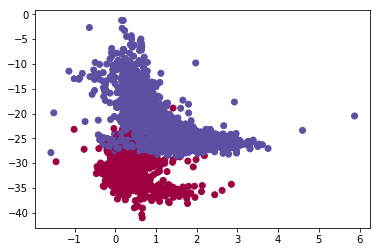

In [59]:
plt.scatter(labelframe[4]["G_minus_R"], labelframe[4]['M_Absolute'], c=labelframe[4]["SVM_class"],  marker="o", cmap="Spectral")

In [60]:
knn_model = KNeighborsClassifier(n_neighbors=20)
knn_model.fit(X_train, y_train)

knn_y_pred = knn_model.predict(X_test)
metrics.accuracy_score(y_true = y_test, y_pred=knn_y_pred)

labelframe[4]["KNN_class"] = knn_y_pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


In [54]:
metrics.confusion_matrix(y_true = y_test, y_pred=knn_y_pred)

array([[ 3791,   244],
       [   68, 17242]], dtype=int64)

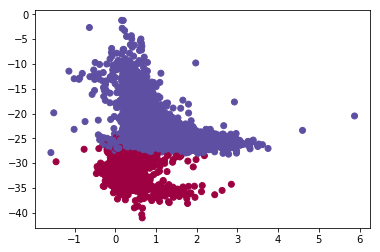

In [62]:
plt.scatter(labelframe[4]["G_minus_R"], labelframe[4]['M_Absolute'], c=labelframe[4]["KNN_class"],  marker="o", cmap="Spectral")